This script illustrates how to denoise an EM slice with the DPIR method: https://arxiv.org/pdf/2008.13751.pdf. 

We will start by loading in the required modules and configuring the environment. 

In [1]:
# configure environment
import sys
DPIR_DIR = '/home/jorisro/research/DPIR'  # adjust this if necessary! This should point to the DPIR repository
sys.path.append('/home/jorisro/research/neuralnets')  # adjust this if necessary! This should point to the neuralnets repository
sys.path.append(DPIR_DIR)  

# dependencies
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import urllib

from neuralnets.util.io import print_frm, read_volume

from models.network_unet import UNetRes as net
from utils import utils_model

Denoising often comes with parameter tuning. The following parameters should be tuned according to the application (mainly the noise level is the most impacting parameter). 

In [2]:
# data parameters
bit_depth = 8  # usually 8 or 16, depending on the application

# denoising parameters
noise_level = 0.2  # noise level: increase/decrease for more/less aggressive denoising
bs = 500  # block size for sliding window processing

# advanced parameters: change at own risk!
model_name = 'drunet_gray'  # denoising model: either drunet_gray (grayscale images) or drunet_color (color images)
x8 = True  # x8 to boost performance

# fixed
n_channels = 3 if 'color' in model_name else 1
model_pool = 'model_zoo'
model_path = os.path.join(model_pool, model_name+'.pth')

# prepare device settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

We will now load the dataset that we want to test, normalize it, and add noise to it. 

In [3]:
# extract the volume
print_frm('Loading data')
data_path = '/home/jorisro/research/data/EM/EPFL/volumedata'
data = read_volume(data_path, type='pngseq', progress=True, start=0, stop=100)

# normalize the image
data = np.float32(data / 2**bit_depth)

# add artificial noise to the image
data_noise = data + noise_level * np.random.randn(*(data.shape))

[2022-05-24 12:49:21.006994] Loading data


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 44.62it/s]


As an illustration, we can show a randomly selected sample of this dataset. 

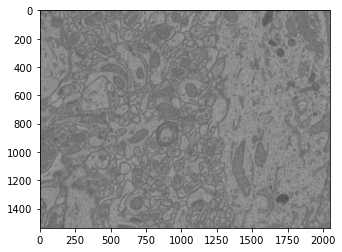

In [4]:
x = data_noise[np.random.randint(len(data))]
plt.imshow(x, cmap='gray')
plt.show()

Now that we have data, it's time to intialize the model! 

In [5]:
model_path_abs = os.path.join(DPIR_DIR, model_path)
if not os.path.exists(model_path_abs):
    print_frm('Downloading model')
    source = 'https://drive.google.com/u/0/uc?id=1oSsLjPPn6lqtzraFZLZGmwP_5KbPfTES&export=download&confirm=t'
    urllib.request.urlretrieve(source, model_path_abs)

print_frm('Building the network')
model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
model.load_state_dict(torch.load(model_path_abs), strict=True)
model.eval()
for k, v in model.named_parameters():
    v.requires_grad = False
model = model.to(device)

[2022-05-24 12:49:34.578879] Building the network


The following functions are necessary for denoising images. 

In [6]:
def resample(x, m=32):
    """
    Apply padding to the image to avoid boudary artifacts

    :param x: input data (shape [Y, X])
    :param m: margin
    :return: a tuple (y, w, h) that contains the padded image y, and the original size (Y, X)
    """

    w, h = x.shape
    w_ = ((w // m) + 1) * m
    h_ = ((h // m) + 1) * m
    y = np.pad(x, ((0, w_ - w), (0, h_ - h)))
    return y, w, h


def crop(x, w, h):
    """
    Crop an input image to a specified shape

    :param x: input data (shape [Y, X])
    :param w: width of the image
    :param h: height of the image
    :return: the cropped image
    """

    return x[:w, :h]


def forward(img_H, model, noise_level, device, x8):
    """
    Apply the model in a forward propagation step

    :param img_H: input image (numpy array, shape [Y, X])
    :param model: denoising model
    :param noise_level: noise level
    :param device: device for computations
    :param x8: x8 boost
    :return: denoised image
    """
    
    # preprocess data
    img_L, w, h = resample(img_H, m=32)
    img_L = torch.from_numpy(np.ascontiguousarray(img_L)).float().unsqueeze(0).unsqueeze(0)
    img_L = torch.cat(
        (img_L, torch.FloatTensor([noise_level]).repeat(1, 1, img_L.shape[2], img_L.shape[3])), dim=1)
    img_L = img_L.to(device)
    
    # apply model
    if not x8 and img_L.size(2) // 8 == 0 and img_L.size(3) // 8 == 0:
        img_E = model(img_L)
    elif not x8 and (img_L.size(2) // 8 != 0 or img_L.size(3) // 8 != 0):
        img_E = utils_model.test_mode(model, img_L, refield=64, mode=5)
    elif x8:
        img_E = utils_model.test_mode(model, img_L, mode=3)
    
    # postprocess model
    img_E = img_E.data.squeeze().float().clamp_(0, 1).cpu().numpy()
    img_E = crop(img_E, w, h)
    img_H = crop(img_H, w, h)

    return img_E


def gaussian_window(size, sigma=1):
    """
    Returns a 2D Gaussian window that can be used for window weighting and merging

    :param size: size of the window
    :param sigma: standard deviation of the gaussian
    :return: the Gaussian window
    """
    
    # half window sizes
    hwx = size[0] // 2
    hwy = size[1] // 2

    # construct mesh grid
    if size[0] % 2 == 0:
        axx = np.arange(-hwx, hwx)
    else:
        axx = np.arange(-hwx, hwx + 1)
    if size[1] % 2 == 0:
        axy = np.arange(-hwy, hwy)
    else:
        axy = np.arange(-hwy, hwy + 1)
    xx, yy = np.meshgrid(axx, axy)

    # normal distribution
    gw = np.exp(-(xx ** 2 + yy ** 2) / (2. * sigma ** 2))

    # normalize so that the mask integrates to 1
    gw = gw / np.sum(gw)

    return gw


def forward_sliding(img_H, model, noise_level, device, x8, bs):
    """
    Apply the model in a forward propagation step

    :param img_H: input image (numpy array, shape [Y, X])
    :param model: denoising model
    :param noise_level: noise level
    :param device: device for computations
    :param x8: x8 boost
    :param bs: block size for sliding window (can be set with respect to GPU memory)
    :return: denoised image
    """

    xs, ys = img_H.shape
    img_E_cum = np.zeros((xs, ys))
    div_cum = np.zeros_like(img_E_cum)
    for x in np.arange(0, xs, bs//2):
        for y in np.arange(0, ys, bs//2):
            
            # extract the window
            img_H_ = img_H[x:x+bs, y:y+bs]
            xs_, ys_ = img_H_.shape
            
            # get a gaussian window to avoid boundary artifacts
            gw = gaussian_window((ys_, xs_), sigma=bs/50)
            
            # apply the model
            img_E_ = forward(img_H_, model, noise_level, device, x8)
            
            # cumulate results
            img_E_cum[x:x+xs_, y:y+ys_] = img_E_cum[x:x+xs_, y:y+ys_] + gw*img_E_
            div_cum[x:x+xs_, y:y+ys_] = div_cum[x:x+xs_, y:y+ys_] + gw
        
    # merge results
    img_E = img_E_cum / div_cum
    img_E = img_E.astype(img_H.dtype)

    return img_E

We can now either denoise a (relatively small) image that fits in memory...

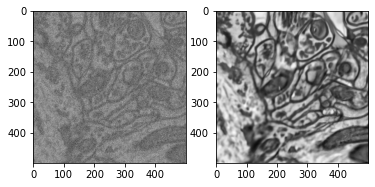

In [7]:
img_H = data_noise[0][:bs, :bs]
img_E = forward(img_H, model, noise_level, device, x8)

# visualize
plt.subplot(1, 2, 1)
plt.imshow(img_H, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_E, cmap='gray')
plt.show()

... or denoise a large slice by using a sliding window! 

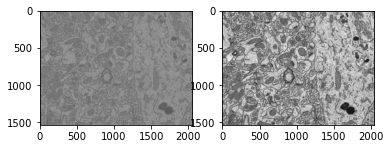

In [8]:
img_H = data_noise[0]
img_E = forward_sliding(img_H, model, noise_level, device, x8, bs)

# visualize
plt.subplot(1, 2, 1)
plt.imshow(img_H, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_E, cmap='gray')
plt.show()

Warning: this might take a few seconds.. it is advised to use a decent GPU and maximize the block size towards the GPU memory for maximum efficiency. 